# HDFS Anomaly Detection using LSTM

## Importing data 

In [ ]:
import os
import pandas as pd
import re
from datetime import datetime
from tqdm import tqdm

from dotenv import load_dotenv

load_dotenv()

BASE_PATH = os.getenv('BASE_PATH')


traces = pd.read_csv(os.path.join(BASE_PATH, 'Raw_logs', 'HDFS_v1', 'preprocessed', 'Event_traces.csv'))
labels = pd.read_csv(os.path.join(BASE_PATH, 'Raw_logs', 'HDFS_v1', 'preprocessed', 'anomaly_label.csv'))
log_templates = pd.read_csv(os.path.join(BASE_PATH, 'Raw_logs', 'HDFS_v1', 'preprocessed', 'HDFS.log_templates.csv'))
log_templates['Regex'] = log_templates['EventTemplate'].apply(lambda t: re.compile(re.escape(t).replace(r'\[\*\]', '.*')))

def map_log_to_event(log_line, templates):
    for _, row in templates.iterrows():
        if row['Regex'].match(log_line):
            return row['EventId']
    return None

def extract_block_id(log_line):
    match = re.search(r'blk_-?\d+', log_line)
    if match:
        return match.group(0)
    return None

log_file_path = os.path.expanduser(os.path.join(BASE_PATH, 'Raw_logs', 'HDFS_v1', 'HDFS.log'))

if not os.path.exists(log_file_path):
    raise FileNotFoundError(f"No such file or directory: '{log_file_path}'")

timestamps = []
event_ids = []
block_ids = []


pickle_file = os.path.join("variables", "data_frame.pkl")
df = None
if not os.path.exists(pickle_file):
    with open(log_file_path, 'r') as file:
        for line in tqdm(file, desc="Processing logs", unit="log"):
            timestamp_match = re.match(r'(\d{6}) (\d{6}) \d+', line)
            if timestamp_match:
                date_str, time_str = timestamp_match.groups()
                timestamp = datetime.strptime(date_str + time_str, "%y%m%d%H%M%S")
            else:
                timestamp = None
            event_id = map_log_to_event(line, log_templates)
            block_id = extract_block_id(line)
            timestamps.append(timestamp)
            event_ids.append(event_id)
            block_ids.append(block_id)
            
    df = pd.DataFrame(
        {
            'Timestamp': timestamps,
                'EventId': event_ids,
            'BlockId': block_ids
        }
    )
    df.to_pickle(pickle_file)
else:
    df = pd.read_pickle(pickle_file)



data = traces.merge(labels, on='BlockId')

data = data[['Features', 'Label_x']]
data.rename(columns={'Label_x': 'Label'}, inplace=True)
data['Label'] = data['Label'].apply(lambda x: 1 if x == 'Fail' else 0)

print(data.head())


## Sliding Window Creation Function

In [2]:
import numpy as np


def create_sliding_windows(event_sequences, label, window_size_local=10, step_size_local=1):
    x1, y1 = [], []
    for i in range(0, len(event_sequences) - window_size_local, step_size_local):
        x1.append(event_sequences[i: i + window_size_local])
        y1.append(label)
    return np.array(x1), np.array(y1)


## Encoding the sequences

In [3]:
from tensorflow.keras.layers import TextVectorization

MAX_LEN = 50
VOCAB_SIZE = len(log_templates['EventId'].unique()) + 1

vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,  # Set your desired vocabulary size
    output_mode='int',
    output_sequence_length=MAX_LEN  # Set your desired sequence length
)

vectorize_layer.adapt(log_templates['EventId'])

2025-04-05 19:54:50.865911: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-04-05 19:54:50.865931: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-04-05 19:54:50.865935: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
I0000 00:00:1743879290.865945  203591 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1743879290.865960  203591 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Applying the window function

In [11]:

if os.path.exists(os.path.join("variables", "x_train.npy")) and os.path.exists(
        os.path.join("variables", "y_train.npy")):
    x_train = np.load(os.path.join("variables", "x_train.npy"))
    y_train = np.load(os.path.join("variables", "y_train.npy"))
else:
    x_all = []
    y_all = []

    window_size = 10
    step_size = 1

    for i in tqdm(range(len(data)), desc="Processing events", unit="log"):
        raw_text = data['Features'][i][1:-1].replace(",", " ")
        x_vectorized = vectorize_layer(raw_text)
        label = data['Label'][i]
        x_windows, y_windows = create_sliding_windows(x_vectorized, label, window_size, step_size)

        x_all.append(x_windows)
        y_all.append(y_windows)

    x_train = np.concatenate(x_all, axis=0)
    y_train = np.concatenate(y_all, axis=0)

print(f"X_Train {x_train.shape}")
print(f"y_train shape: {y_train.shape}")



X_Train (23002360, 10)
y_train shape: (23002360,)


In [10]:
os.makedirs("variables", exist_ok=True)
np.save(os.path.join("variables", "x_train.npy"), x_train)
np.save(os.path.join("variables", "y_train.npy"), y_train)

In [13]:
from sklearn.model_selection import train_test_split

x_train_final, x_test_final, y_train_final, y_test_final = train_test_split(x_train, y_train, test_size=0.2,
                                                                            random_state=42, stratify=y_train)

## Building the LSTM Model

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vectorize_layer.vocabulary_size(), embedding_vector_length))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

modelDropout = Sequential()
modelDropout.add(Embedding(vectorize_layer.vocabulary_size(), embedding_vector_length))
modelDropout.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
modelDropout.add(Dense(1, activation='sigmoid'))
modelDropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'precision', 'recall'])

print(model.summary())
print(modelDropout.summary())

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


## Training the LSTM Model

In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_final),
    y=y_train_final.ravel()
)

# Converter para dicionário:
weights = dict(zip(np.unique(y_train_final), class_weights))

print(weights)

checkpoint = ModelCheckpoint('models/lstm_model_best_dropout.keras', monitor='val_accuracy', save_best_only=True,
                             verbose=1)

# # Train the LSTM model
# modelDropout.fit(x_train_final, y_train_final,
#           validation_data=(x_test_final, y_test_final),
#           epochs=3, batch_size=512,
#           class_weight=weights,
#           callbacks=[checkpoint])


{np.int64(0): np.float64(0.5150809176277539), np.int64(1): np.float64(17.077240601057195)}


# Prediction Stage

In [42]:
def map_log_to_event(raw_log: str) -> str:
    # Example using simple keyword matching (for illustration)
    if "Adding an already existing block" in raw_log:
        return "E1"
    # Add other mappings here...
    return "UNKNOWN"

In [43]:
raw_logs = [
    "081111 043936 19784 WARN dfs.DataBlockScanner: Adding an already existing block blk_-2074..."
]

event_sequence = [map_log_to_event(log) for log in raw_logs]

In [44]:
text_input = " ".join(event_sequence)
x_vectorized = vectorize_layer(text_input)
x_windows, _ = create_sliding_windows(x_vectorized, None)
predictions = model.predict(x_windows)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


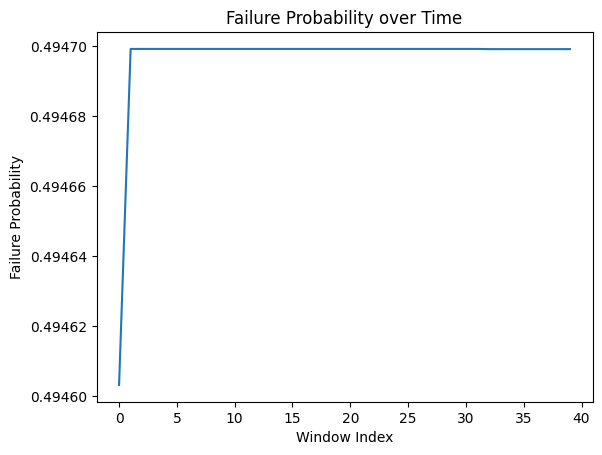

In [45]:
import matplotlib.pyplot as plt

plt.plot(predictions)
plt.title("Failure Probability over Time")
plt.xlabel("Window Index")
plt.ylabel("Failure Probability")
plt.show()
